# Setup colab gang

> **IMPORTANT**
> Nel caso si utilizzi google Colab c'è da caricare i file di input.

In [16]:
#from google.colab import drive
#
#drive.mount('/content/drive')

path = '/content/drive/MyDrive/PoliMI/Dataset1_BankClients.xlsx'

# Setup locale

In [17]:
# Path su linux
path = './data/Dataset1_BankClients.xlsx'

# Path su windows - comando da inserire 
#path = ' '

# Utility Functions


In [28]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.decomposition import PCA
from sklearn.decomposition import FastICA

import numpy as np
import matplotlib.pyplot as plt

def get_optimal_k_voting(X, cluster_results, gower_distances):
    """
    Determine the optimal number of clusters (k) by voting among different metrics.
    
    Parameters:
    - X: Dataset (used for Calinski-Harabasz and Davies-Bouldin scores)
    - cluster_results: Dictionary where keys are k values and values are cluster assignments
    - gower_distances: Precomputed Gower distance matrix (used for Silhouette score)
    
    Returns:
    - optimal_k: The optimal number of clusters based on the median of suggested k values
    """
    
    if not cluster_results:
        raise ValueError("cluster_results cannot be empty")
    
    k_values = list(cluster_results.keys())
    
    # Validate cluster assignments
    for k, assignments in cluster_results.items():
        if len(assignments) != len(X):
            raise ValueError(f"Cluster assignments for k={k} do not match dataset size")
    
    # Get optimal k for each metric
    try:
        ch_optimal = k_values[np.argmax(calinski_harabasz_score(X, cluster_results[k]) for k in k_values)]
        # print("DEBUG: ", ch_optimal)
        # print("Calinski-Harabasz Score (k=3):", calinski_harabasz_score(X, cluster_results[3]))
        # print("Calinski-Harabasz Score (k=4):", calinski_harabasz_score(X, cluster_results[4]))
    except ValueError as e:
        print(f"Warning: Calinski-Harabasz score failed. Skipping. Error: {e}")
        ch_optimal = None
    
    try:
        db_scores = {k: davies_bouldin_score(X, cluster_results[k]) for k in k_values}
        db_optimal = min(db_scores, key=db_scores.get)
        
        # print("DEBUG: ", db_optimal)
        # print("Davies-Bouldin Score (k=3):", db_scores[3])
        # print("Davies-Bouldin Score (k=4):", db_scores[4])
    except ValueError as e:
        print(f"Warning: Davies-Bouldin score failed. Skipping. Error: {e}")
        db_optimal = None

    
    try:
        # Correctly identify the optimal k based on the Silhouette score
        sil_scores = {k: silhouette_score(gower_distances, cluster_results[k], metric='precomputed') for k in k_values}
        sil_optimal = max(sil_scores, key=sil_scores.get)
        
        # print("DEBUG: ", sil_optimal)
        # print("Silhouette Score (k=3):", sil_scores[3])
        # print("Silhouette Score (k=4):", sil_scores[4])
    except ValueError as e:
        print(f"Warning: Silhouette score failed. Skipping. Error: {e}")
        sil_optimal = None
    
    # Collect valid suggestions
    suggestions = [k for k in [ch_optimal, db_optimal, sil_optimal] if k is not None]
    print("Suggestions:", suggestions)
    
    if not suggestions:
        raise ValueError("No valid suggestions from metrics")
    
    # Get median k
    optimal_k = int(np.median(suggestions))
    
    # Print results
    print("\nVoting Results:")
    if ch_optimal is not None:
        print(f"Calinski-Harabasz score: {calinski_harabasz_score(X, cluster_results[ch_optimal])}")
    if db_optimal is not None:
        print(f"Davies-Bouldin score: {davies_bouldin_score(X, cluster_results[db_optimal])}")
    if sil_optimal is not None:
        print(f"Silhouette score: {silhouette_score(gower_distances, cluster_results[sil_optimal], metric='precomputed')}")
    print(f"\nFinal decision (median): {optimal_k} clusters")
    
    return optimal_k

def visualize_cluster(X, clusters):
    """
    Visualize the clustering results in 2D and 3D space using PCA and ICA.
    
    Parameters:
    - X: Dataset
    - clusters: Cluster assignments
    """
    
    # PCA
    pca = PCA(n_components=3)  # 3 PC
    X_pca = pca.fit_transform(X)

    # Create a figure with two subplots side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

    # 2D Embedding
    ax1.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, alpha=0.8)
    ax1.set_title('2-D Embedding with PCA', fontsize=14)
    ax1.set_xlabel('Principal Component 1')
    ax1.set_ylabel('Principal Component 2')
    ax1.grid(True, alpha=0.3)

    # 3D Embedding
    ax2 = fig.add_subplot(122, projection='3d')
    ax2.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], facecolor=(0, 0.25, 0.85), c=clusters, alpha=0.8)
    ax2.set_title('3-D Embedding with PCA', fontsize=14)
    ax2.set_xlabel('Principal Component 1')
    ax2.set_ylabel('Principal Component 2')
    ax2.set_zlabel('Principal Component 3')
    ax2.view_init(elev=15, azim=-30)

    plt.tight_layout()
    plt.show()

    # ICA
    ica = FastICA(n_components=3, random_state=42)
    X_ica = ica.fit_transform(X)  # Trasformazione dei dati

    # Create a figure with two subplots side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

    # 2D Embedding
    ax1.scatter(X_ica[:, 0], X_ica[:, 1], c=clusters, alpha=0.8)
    ax1.set_title('2-D Embedding with PCA', fontsize=14)
    ax1.set_xlabel('Principal Component 1')
    ax1.set_ylabel('Principal Component 2')
    ax1.grid(True, alpha=0.3)

    # 3D Embedding
    ax2 = fig.add_subplot(122, projection='3d')
    ax2.scatter(X_ica[:, 0], X_ica[:, 1], X_ica[:, 2], facecolor=(0, 0.25, 0.85), c=clusters, alpha=0.8)
    ax2.set_title('3-D Embedding with PCA', fontsize=14)
    ax2.set_xlabel('Principal Component 1')
    ax2.set_ylabel('Principal Component 2')
    ax2.set_zlabel('Principal Component 3')
    ax2.view_init(elev=15, azim=-30)

    plt.tight_layout()
    plt.show()




# Data Loading

In [19]:
import pandas as pd

# Load data in a DataFrame
data = pd.read_excel(path)

# Let's inspect the first 5 record
print(data.head())
# Drop the column by its actual name (e.g., 'ID' or the actual name of the column)
data = data.drop(columns=['ID'])  # Replace 'ID' with the actual column name to drop

   ID  Age  Gender  Job  Area  CitySize  FamilySize    Income    Wealth  \
0   1   24       1    1     2         2           4  0.668046  0.702786   
1   2   47       1    2     2         3           1  0.858453  0.915043   
2   3   38       0    2     1         2           2  0.926818  0.898316   
3   4   67       0    2     1         2           3  0.538797  0.423180   
4   5   33       0    2     1         3           1  0.806659  0.731404   

       Debt    FinEdu       ESG   Digital  BankFriend  LifeStyle    Luxury  \
0  0.262070  0.741853  0.483684  0.698625    0.618259   0.607877  0.897369   
1  0.730430  0.859423  0.537167  0.959025    0.785936   0.862271  0.913729   
2  0.441272  0.485953  0.649434  0.750265    0.699725   0.755404  0.765199   
3  0.600401  0.493144  0.533829  0.590165    0.675353   0.334432  0.517209   
4  0.831449  0.856286  0.784940  0.710026    0.758793   0.908878  0.611610   

     Saving  Investments  
0  0.283222            1  
1  0.821590            3  

# Data Preparation  

In [20]:
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
import numpy as np

# Specify categorical variables
#categorical_columns = ['Gender', 'Job', 'Area', 'CitySize', 'Investments']
categorical_columns = ['Gender', 'Job', 'Area', 'CitySize']


# Split variables
numerical_features = data.drop(columns=categorical_columns)  # Exclude categorical variables
categorical_features = data[categorical_columns]  # Select categorical variables

# Convert categorical in typ 'category' (for OneHotEncoder)
categorical_features = categorical_features.astype('category')

# Normalize numerical variables
scaler = MinMaxScaler()
X_num = scaler.fit_transform(numerical_features)

# One-hot encoding categorical variables
encoder = OneHotEncoder(drop='first', handle_unknown='ignore')  # Dummy encoding - set 1 feature to all 0s - ignoring unknwown values
X_cat = encoder.fit_transform(categorical_features).toarray()  # Convert into a dense matrix

# Concatenation of numerical and categorical variables
X = np.hstack((X_num, X_cat))

# Summary of the dataset
print("Numerical Features Shape:", X_num.shape)
print("Categorical Features Shape:", X_cat.shape)
print("Combined Features Shape:", X.shape)


Numerical Features Shape: (5000, 13)
Categorical Features Shape: (5000, 9)
Combined Features Shape: (5000, 22)


# Data Exploration 

Firstly, control covariances of numerical features between features and target variable. We can see that the most correlated features have a correlation of 0.05

Covariance Matrix Shape: (13, 13)


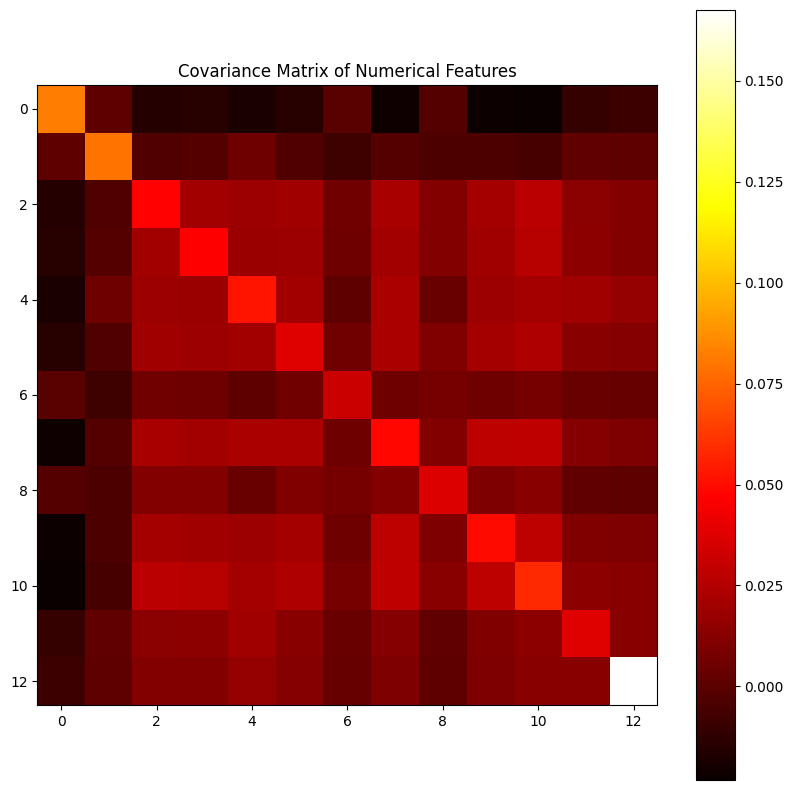

In [21]:
import matplotlib.pyplot as plt

# Covariance matrix of numerical features
cov_matrix = np.cov(X_num.T)
print("Covariance Matrix Shape:", cov_matrix.shape) 

# Plot the covariance matrix
plt.figure(figsize=(10, 10))
plt.imshow(cov_matrix, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.title('Covariance Matrix of Numerical Features')
plt.show()

# Clustering 

In [22]:
# PCA - Principal Component Analysis

from sklearn.decomposition import PCA

# PCA model
pca = PCA(n_components= X.shape[1])  # Number of components = number of features
X_pca = pca.fit_transform(X)

# Print cumulative explained variance of each principal component
print("Explained Variance Ratio:\n", pca.explained_variance_ratio_)

# First 20 principal components
print("First 20 Principal Components:\n", sum(pca.explained_variance_ratio_[:20]))



Explained Variance Ratio:
 [0.21485734 0.14723348 0.1169934  0.07806365 0.0732614  0.06719491
 0.04227809 0.03779204 0.03418701 0.03310896 0.02759733 0.01673283
 0.01519405 0.01366384 0.01269194 0.01225025 0.0112162  0.01104536
 0.0098865  0.00963804 0.00863183 0.00648154]
First 20 Principal Components:
 0.9848866252704285


**REFERENCE**: https://stackoverflow.com/questions/15050389/estimating-choosing-optimal-hyperparameters-for-dbscan

/tmp/ipykernel_12424/3420588300.py:11: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(gower_distance, method='ward')


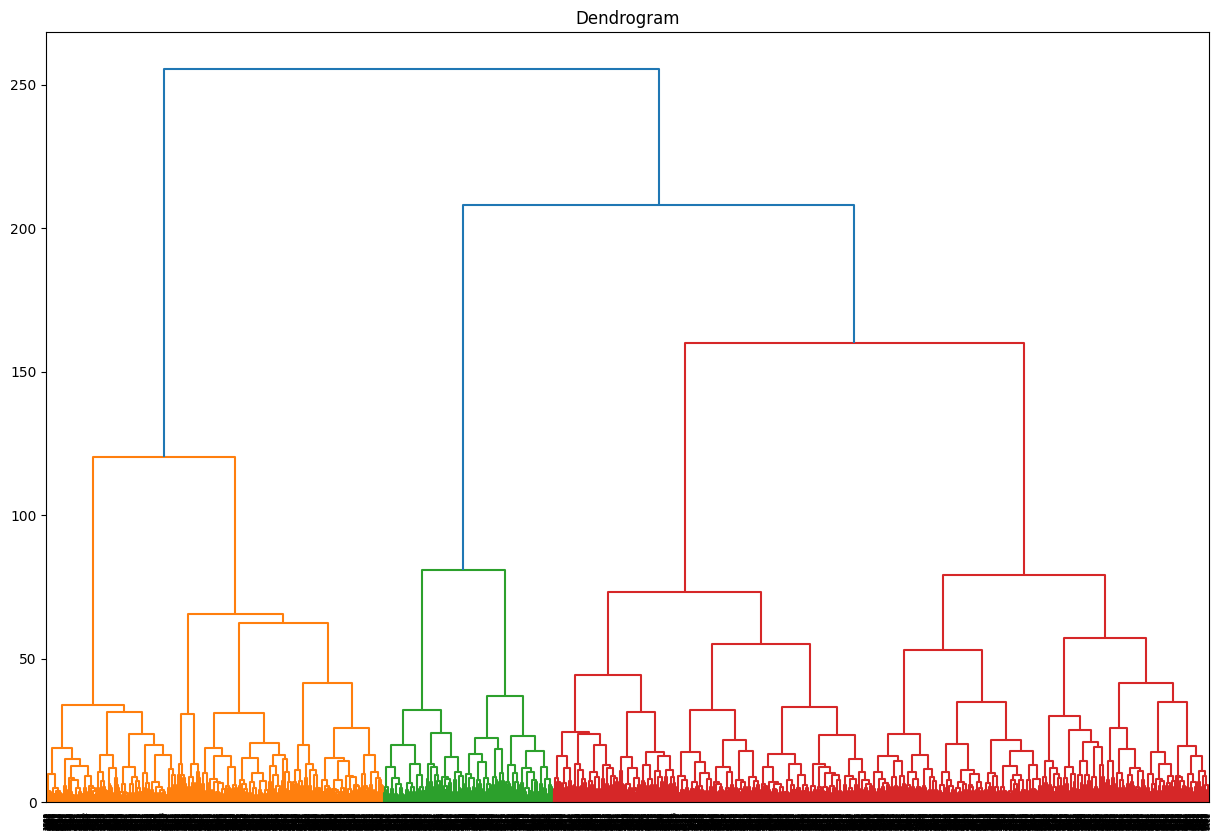

Number of Clusters (k=3): 3
Number of Clusters (k=4): 4
Silhouette Score (k=3): 0.16274703
Silhouette Score (k=4): 0.17566182
Suggestions: [3, 4, 4]

Voting Results:
Calinski-Harabasz suggests: 3 clusters
Davies-Bouldin suggests: 4 clusters
Silhouette suggests: 4 clusters

Final decision (median): 4 clusters


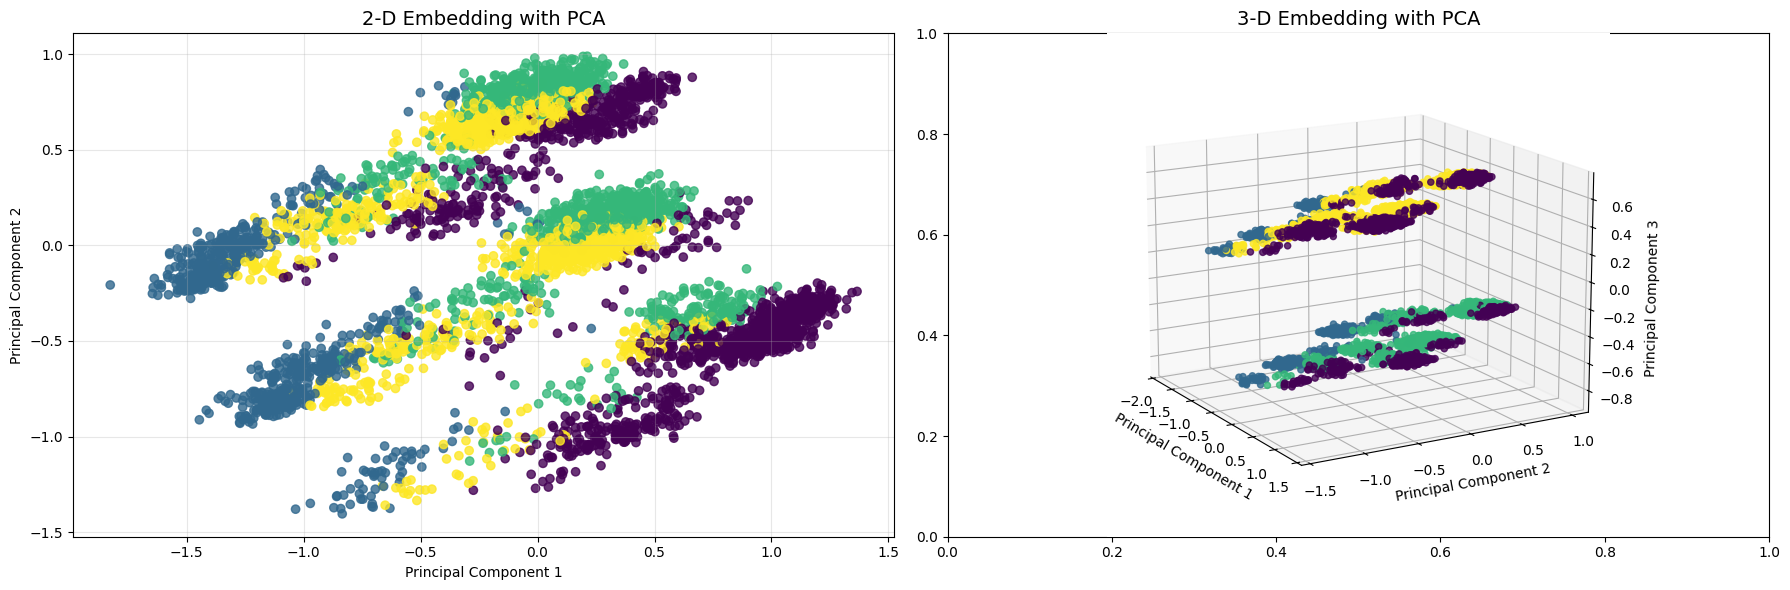

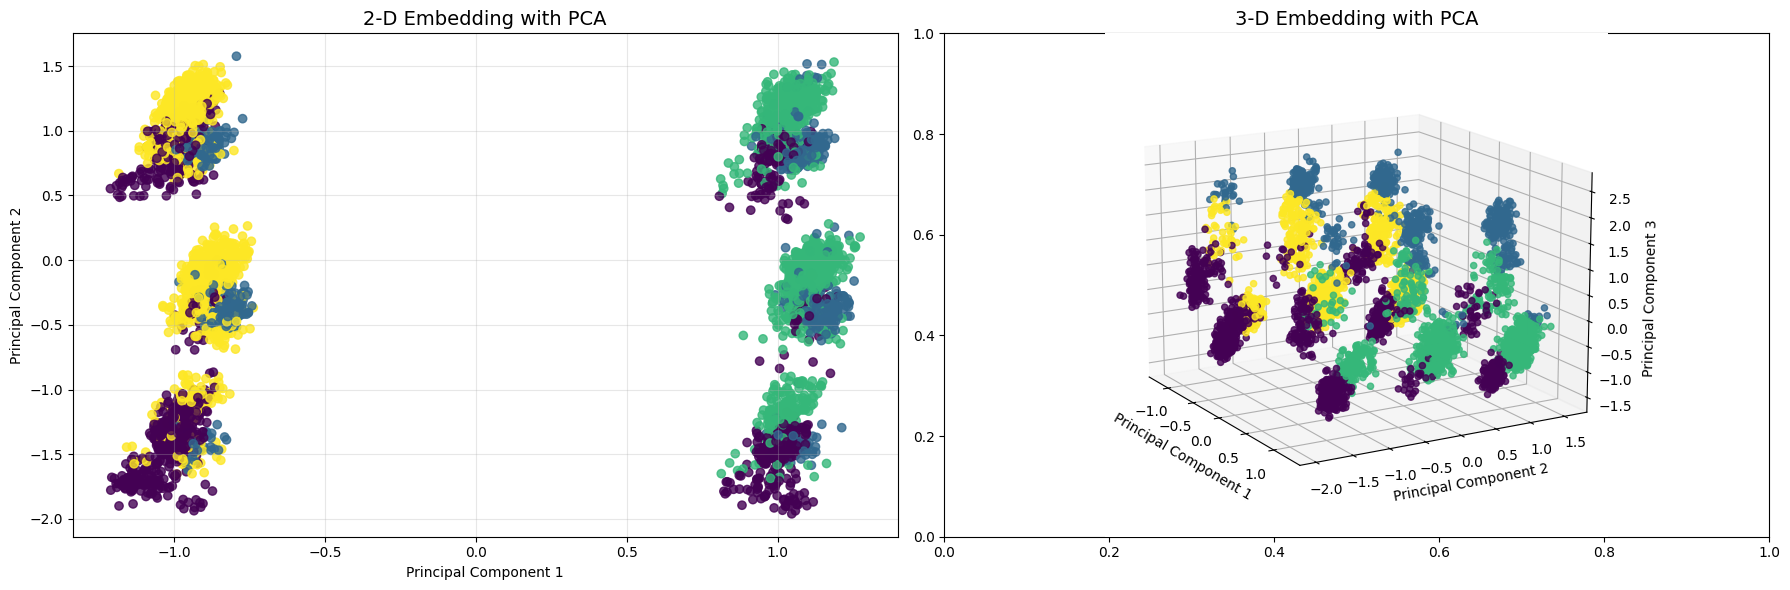

In [23]:
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import matplotlib.pyplot as plt
import numpy as np
import gower

# Compute Gower distance matrix
gower_distance = gower.gower_matrix(data)

# Perform hierarchical clustering
Z = linkage(gower_distance, method='ward')

# Plot dendrogram
plt.figure(figsize=(15, 10))
dendrogram(Z)
plt.title('Dendrogram')
plt.show()

# Cut the dendrogram at a certain height to obtain clusters
cluster3 = fcluster(Z, 3, criterion='maxclust')
cluster4 = fcluster(Z, 4, criterion='maxclust')

# Print the number of clusters
print("Number of Clusters (k=3):", len(np.unique(cluster3)))
print("Number of Clusters (k=4):", len(np.unique(cluster4)))

# Silhouette score for k=3
silhouette_score3 = silhouette_score(gower_distance, cluster3, metric='precomputed')
print("Silhouette Score (k=3):", silhouette_score3)

# Silhouette score for k=4
silhouette_score4 = silhouette_score(gower_distance, cluster4, metric='precomputed')
print("Silhouette Score (k=4):", silhouette_score4)

cluster_results = {}
cluster_results[3] = cluster3
cluster_results[4] = cluster4

# Get the optimal k through robust voting
final_k = get_optimal_k_voting(X, cluster_results, gower_distance)
visualize_cluster(X, cluster_results[final_k])


Suggestions: [3, 3, 4]

Voting Results:
Calinski-Harabasz suggests: 3 clusters
Davies-Bouldin suggests: 3 clusters
Silhouette suggests: 4 clusters

Final decision (median): 3 clusters


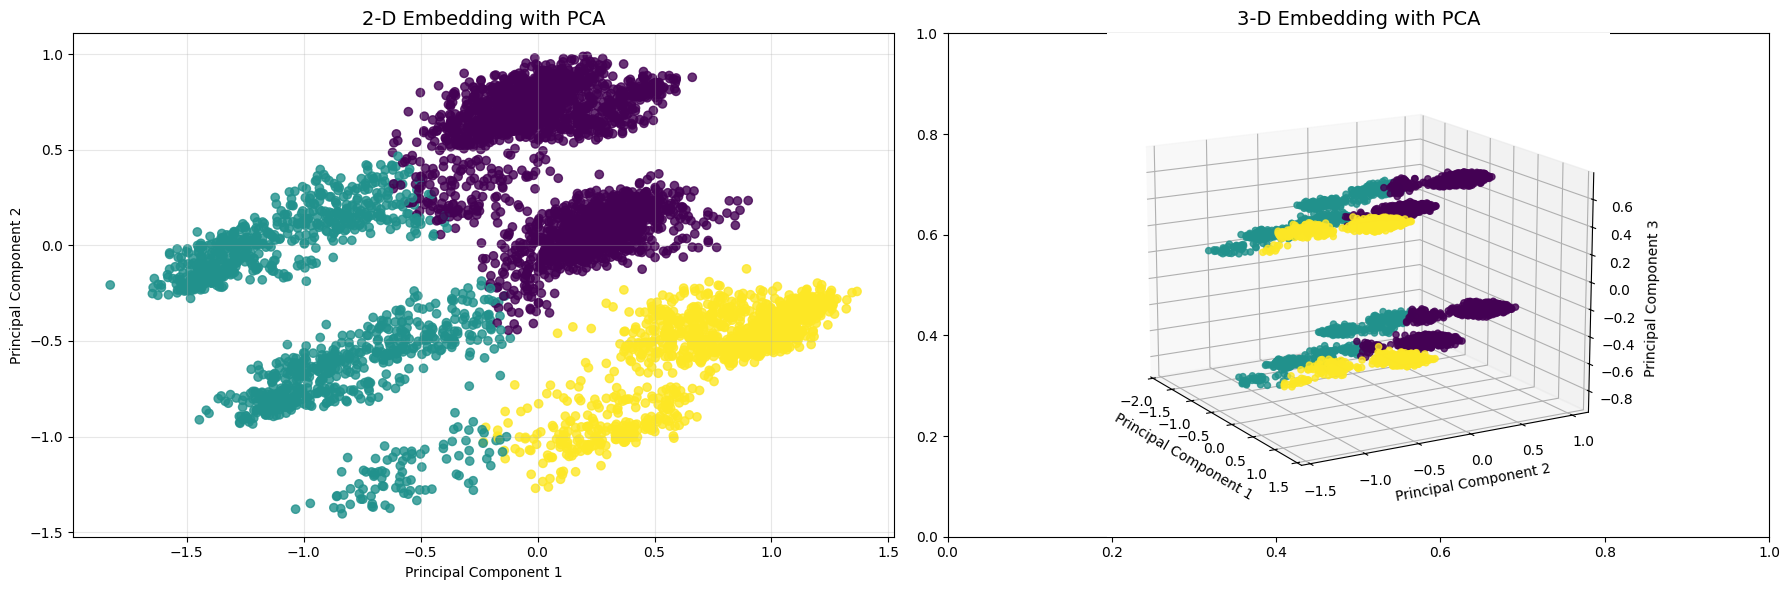

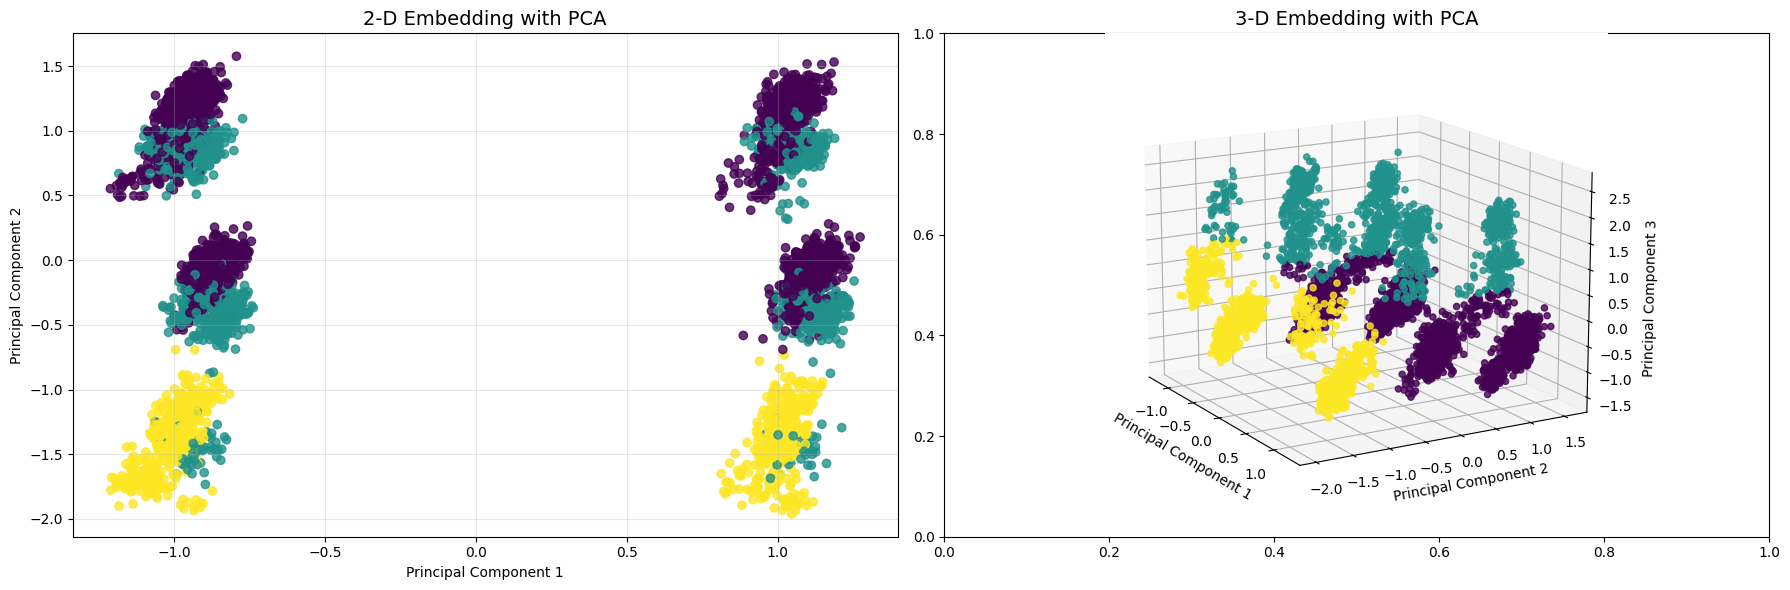

In [24]:
from sklearn.cluster import KMeans

# KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(X)
kmeans_clusters3 = kmeans.predict(X)

# KMeans clustering
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(X)
kmeans_clusters4 = kmeans.predict(X)

# Choose the optimal number of clusters
cluster_results = {}
cluster_results[3] = kmeans_clusters3
cluster_results[4] = kmeans_clusters4
final_k = get_optimal_k_voting(X, cluster_results, gower_distance)

# Visualize the clustering results
visualize_cluster(X, cluster_results[final_k])


Suggestions: [3, 4, 3]

Voting Results:
Calinski-Harabasz score: 2701.486730373388
Davies-Bouldin score: 0.8461720144904482
Silhouette score: 0.18090495467185974

Final decision (median): 3 clusters


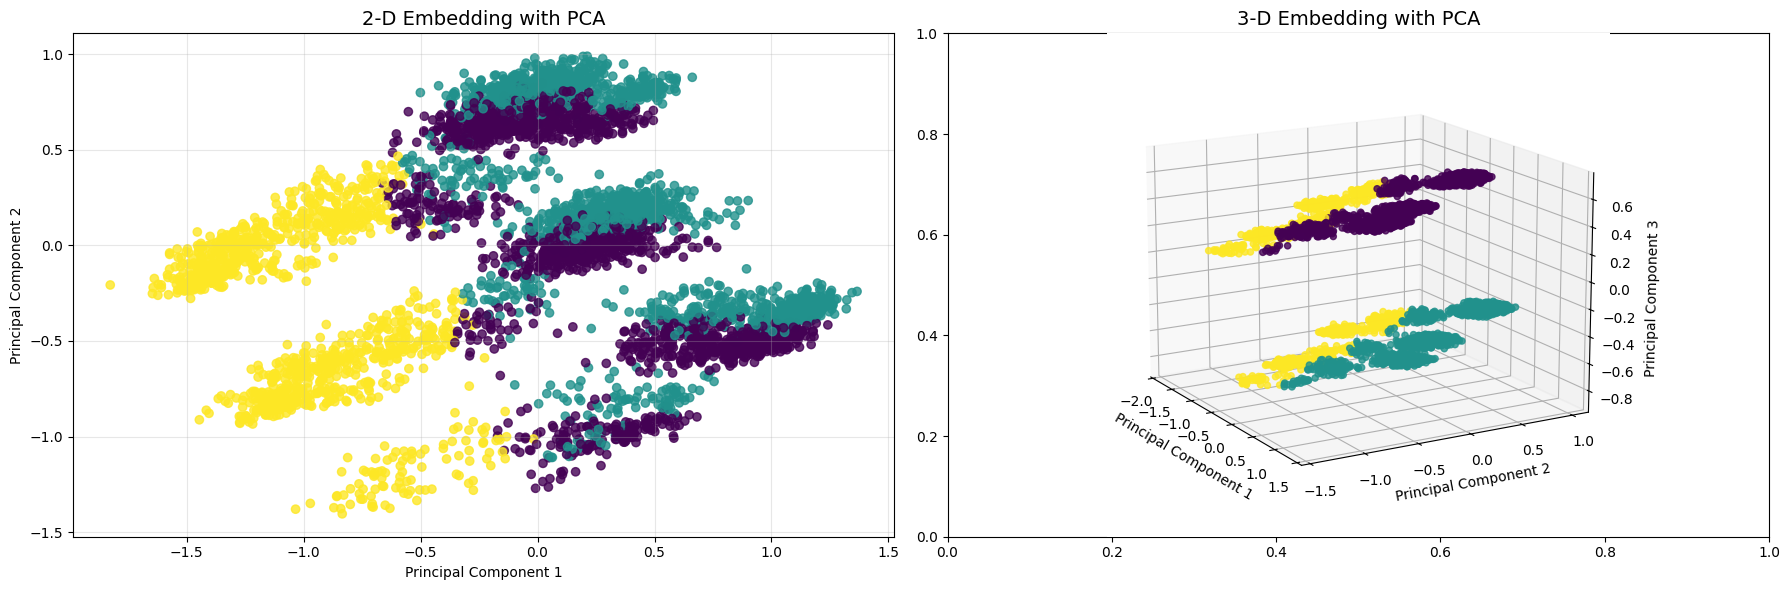

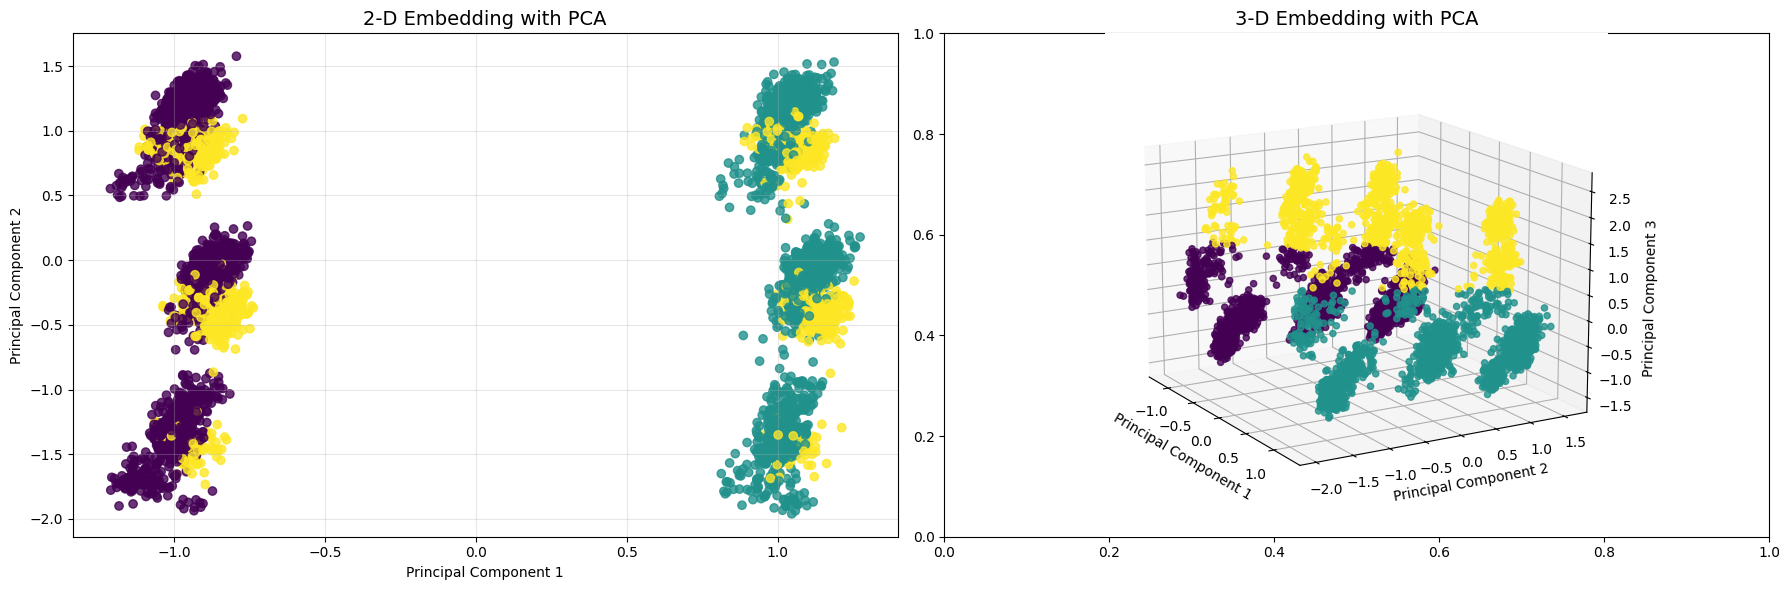

In [29]:
from sklearn.cluster import KMeans

# PCA
pca = PCA(n_components=3)  # 3 PC
X_pca = pca.fit_transform(X)

# KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(X_pca)
kmeans_clusters3 = kmeans.predict(X_pca)

# KMeans clustering
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(X_pca)
kmeans_clusters4 = kmeans.predict(X_pca)

# Choose the optimal number of clusters
cluster_results = {}
cluster_results[3] = kmeans_clusters3
cluster_results[4] = kmeans_clusters4
final_k = get_optimal_k_voting(X_pca, cluster_results, gower_distance)
visualize_cluster(X, cluster_results[final_k])


Suggestions: [3, 4, 3]

Voting Results:
Calinski-Harabasz score: 826.7288049023387
Davies-Bouldin score: 1.9816258435778957
Silhouette score: 0.18585172295570374

Final decision (median): 3 clusters


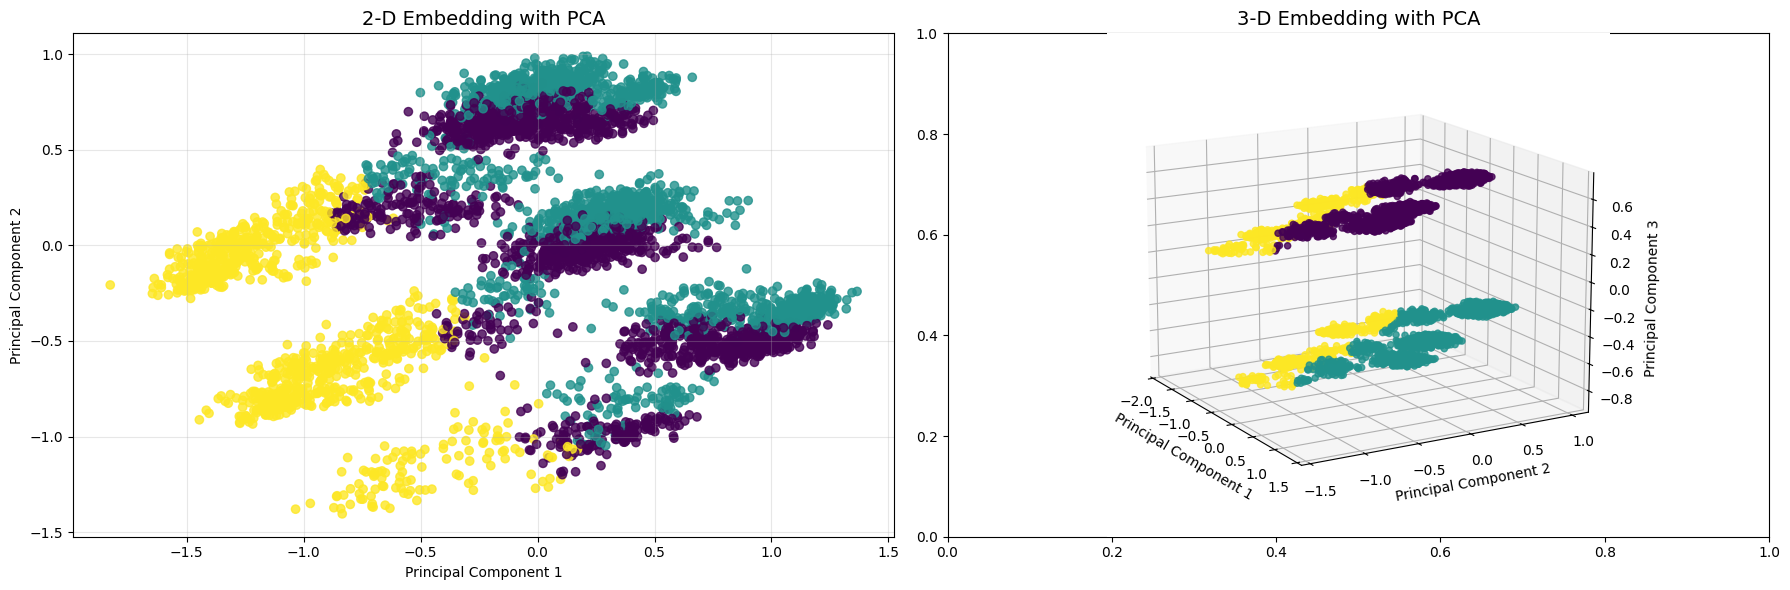

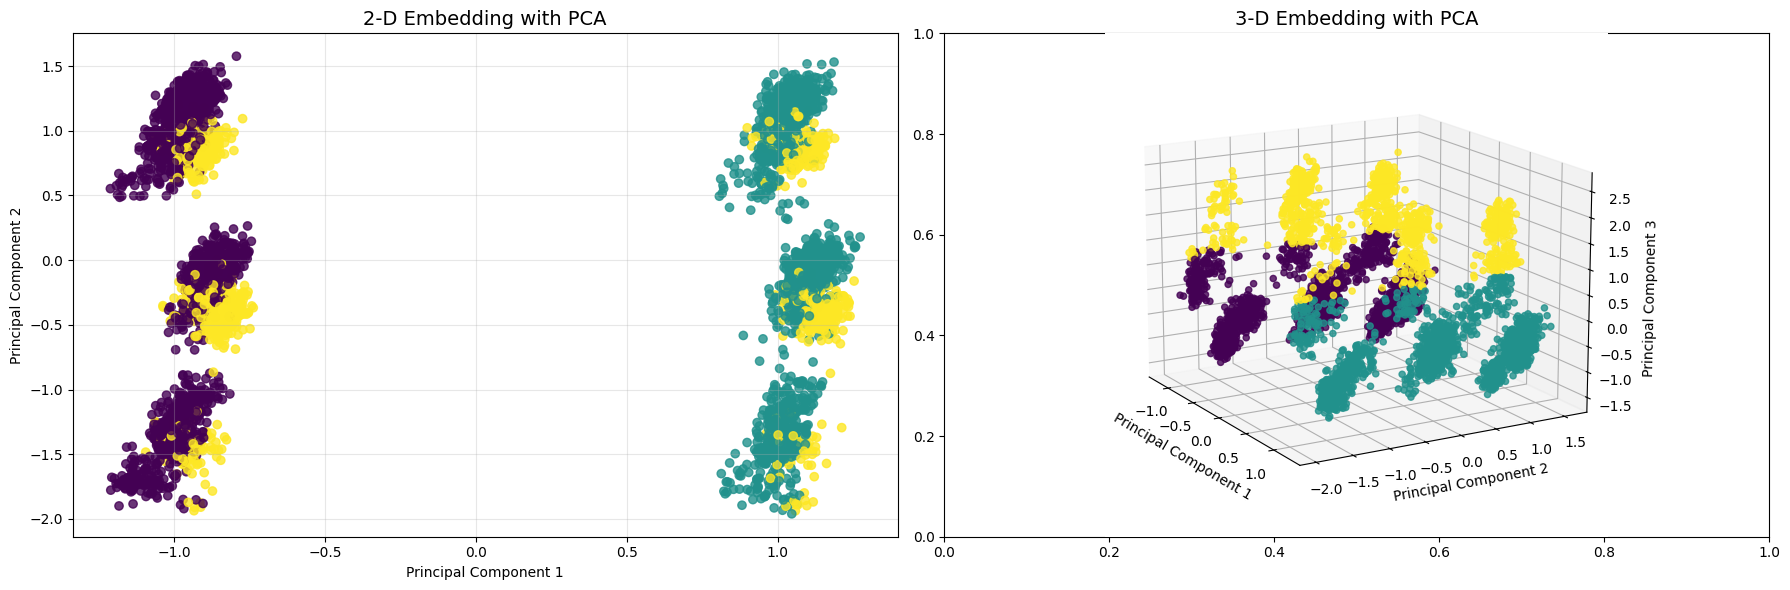

In [31]:
from sklearn.decomposition import FastICA

# PCA
ica = FastICA(n_components=3)  # 3 PC
X_ica = ica.fit_transform(X)

# KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(X_ica)
kmeans_clusters3 = kmeans.predict(X_ica)

# KMeans clustering
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(X_ica)
kmeans_clusters4 = kmeans.predict(X_ica)

# Choose the optimal number of clusters
cluster_results = {}
cluster_results[3] = kmeans_clusters3
cluster_results[4] = kmeans_clusters4
final_k = get_optimal_k_voting(X, cluster_results, gower_distance)
visualize_cluster(X, cluster_results[final_k])